# Docker BRATS results

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import os
import seaborn as sb
from pprint import pprint
%matplotlib inline

In [133]:
#set baseline variables for export and stuff
res = 400 # dpi value for image export
form = 'png' #image format for matplotlib exports

#import data
data = pandas.read_csv('wt_clean.csv')
data = data.drop('Unnamed: 0', axis=1)
#rename colums to their 3 character IDs
candidates = {
        'aju' : 'tumor_istb_aj_class.nii',
        'aca' : 'data_data_prediction.nii.gz',
        'kch' : 'tumor_qtimlab_class.nii.gz',
        'ekr' : 'tumor_00000000_class.nii.gz',
        'aka' : 'tumor_kamleshp_class.nii.gz',
        'mag' : 'tumor_magnrbm_class.nii',
        'sse' : 'tumor_saras_tb_class.nii.gz',
        'rsa': 'tumor_gevaertlab_class.nii',
        'gwa' : 'brats_dc_brats2016_test_klhd_pat101_3.nii.gz',
        'ise' : 'tumor_brats2017_isensee_class.nii.gz',
        'mav' : 'majvote_fusion.nii.gz',
        'none' : 'default'
    }
#invert the indices to assign the proper labels
inv_cand = {v: k for k, v in candidates.items()}
data = data.rename(inv_cand, axis=1)

In [138]:
#sort the indices by their mean value and reorder the data frame for descending plotting
m = data.mean()
m_sorted = m.sort_values(ascending=False)
pprint(m_sorted)
print('')
pprint(data.std().sort_values(ascending=False))
indices = m_sorted.keys()
# order dataframe by mean
indices = indices.tolist()
wt_ordered = data[indices]

mav    0.797255
aju    0.797011
ise    0.785247
ekr    0.775286
kch    0.765547
aca    0.755070
gwa    0.747350
rsa    0.745304
aka    0.708905
mag    0.631775
dtype: float64
mag    0.293129
rsa    0.215304
gwa    0.212245
ise    0.201668
aka    0.201247
kch    0.198085
aca    0.195182
ekr    0.188270
mav    0.181714
aju    0.169861
dtype: float64


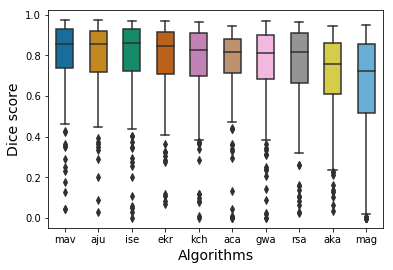

In [135]:
# fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
bplot = sb.boxplot(data=wt_ordered, 
                 width=0.5,
                 palette="colorblind")
#bplot.axes.set_title('DICE Scores for whole tumor', fontsize=16)
bplot.set_xlabel('Algorithms', fontsize=14)
bplot.set_ylabel('Dice score', fontsize=14)
bplot.figure.savefig('wt_fullplot.png', format=form, dpi=res)

Text(21.200000000000003, 0.5, 'Dice score')

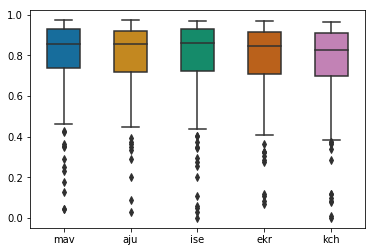

In [136]:
results = np.split(wt_ordered, [5], axis=1)
bplot1 = sb.boxplot(data=results[0], 
                 width=0.5,
                 palette="colorblind")
#bplot.axes.set_title('DICE Scores for whole tumor', fontsize=16)
bplot.set_xlabel('Algorithms', fontsize=14)
bplot.set_ylabel('Dice score', fontsize=14)

Text(21.200000000000003, 0.5, 'Dice score')

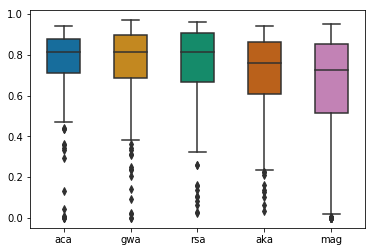

In [127]:
bplot2 = sb.boxplot(data=results[1], 
                 width=0.5,
                 palette="colorblind")
#bplot.axes.set_title('DICE Scores for whole tumor', fontsize=16)
bplot.set_xlabel('Algorithms', fontsize=14)
bplot.set_ylabel('Dice score', fontsize=14)

In [129]:
#save all of it
bplot1.figure.savefig('wt_boxplot1.png', format=form, dpi=res)
bplot2.figure.savefig('wt_boxplot2.png', format=form, dpi=res)